In [187]:
import pandas as pd
import numpy as np 
from statsmodels.sandbox.stats.runs import runstest_1samp # prueba de rachas de Wald y Wolfowitz
import statsmodels.api as sm # prueba de Box-Pierce y la modificación de Ljung-Box
from matplotlib import pyplot as plt # gráficos 
import pylab as py
from scipy import stats
from datetime import datetime
from dateutil.relativedelta import relativedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [487]:
url = 'https://github.com/carlosjara/MCD_FAII/blob/main/RECURSOS/content/datosEmpleo.xlsx?raw=true'
#data = pd.read_excel("content/datosEmpleo.xlsx",index_col='mes',parse_dates=True)
data = pd.read_excel(url,index_col='mes',parse_dates=True)
data.head()

,TD_13ciudades,Ocupados,Desocupados,Inactivos
mes,,,,
2001-01-01,20.946380,6923.604,1834.507,4600.718
2001-02-01,19.894213,7037.746,1747.820,4596.805
2001-03-01,19.221565,6945.973,1652.823,4807.120
2001-04-01,17.888575,6973.079,1519.137,4937.280
2001-05-01,17.945654,6994.462,1529.720,4928.911


In [488]:
## Dummies
month_dummies = pd.get_dummies(data.index.month,drop_first=True).set_index(data.index)

y = data["Ocupados"]
X = sm.add_constant(month_dummies)
sea = sm.OLS(y,X)
season = sea.fit()
data_dummie = pd.concat([X, y], axis=1)
print(season.summary())


                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                 -0.038
Method:                 Least Squares   F-statistic:                    0.2787
Date:                Sun, 18 Feb 2024   Prob (F-statistic):              0.989
Time:                        00:22:40   Log-Likelihood:                -1886.0
No. Observations:                 220   AIC:                             3796.
Df Residuals:                     208   BIC:                             3837.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8808.2176    301.805     29.185      0.0

In [489]:
#Matriz de resultados
Resultados_columnas = ['Modelo', 'Configuración', 'RMSE', 'Coef R2']
Resultados = pd.DataFrame(columns=Resultados_columnas)

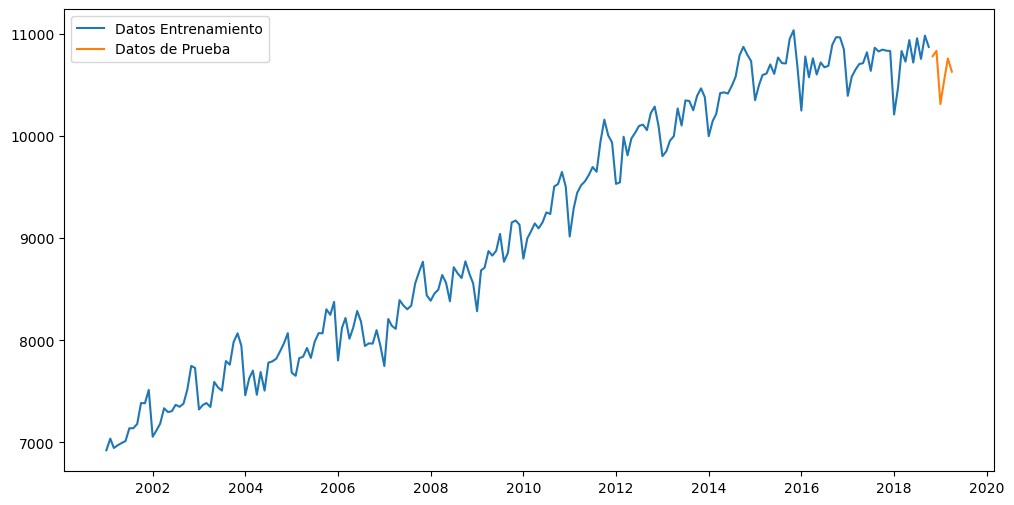

In [490]:
train_len = 214
train_td = data_dummie[["Ocupados"]][:train_len]
test_td = data_dummie[["Ocupados"]][train_len:]

#train_td = data_dummie[:train_len]
#test_td = data_dummie[train_len:]


fig = plt.figure(figsize=(12, 6))
plt.plot(train_td[["Ocupados"]],label="Datos Entrenamiento")
plt.plot(test_td[["Ocupados"]],label="Datos de Prueba")
plt.legend()
plt.show()

## **Modelos**

### Tendencia Lineal

In [491]:
y = train_td["Ocupados"]
month_dummies = pd.get_dummies(train_td.index.month,drop_first=True).set_index(train_td.index)

X = sm.add_constant(month_dummies)
lin = sm.OLS(y,X)
lin_t = lin.fit()
print(lin_t.summary())

                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                 -0.036
Method:                 Least Squares   F-statistic:                    0.3250
Date:                Sun, 18 Feb 2024   Prob (F-statistic):              0.980
Time:                        00:22:41   Log-Likelihood:                -1833.0
No. Observations:                 214   AIC:                             3690.
Df Residuals:                     202   BIC:                             3730.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8724.5387    308.067     28.320      0.0

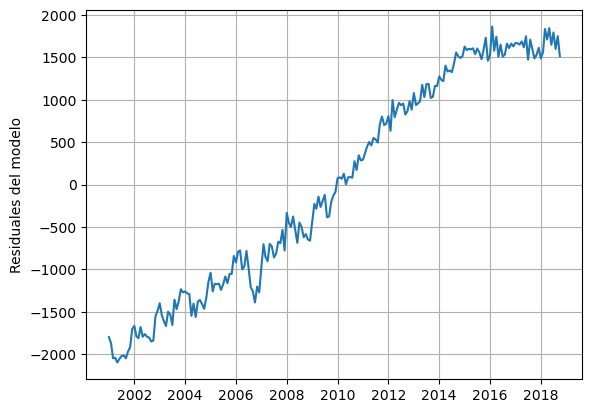

In [492]:
plt.ylabel("Residuales del modelo")
plt.plot(lin_t.resid)
plt.grid()

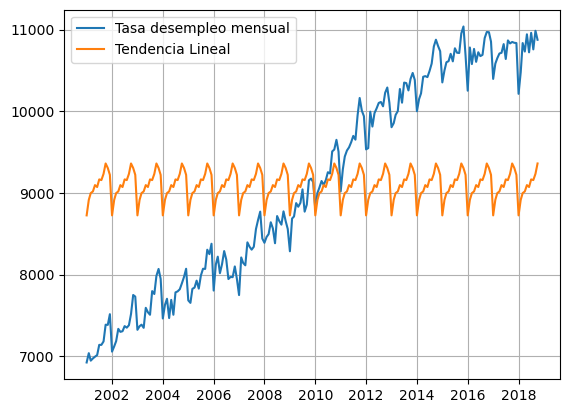

In [493]:
plt.plot(y,label="Tasa desempleo mensual")
plt.plot(lin_t.fittedvalues,label="Tendencia Lineal")
plt.legend()
plt.grid()
plt.show()

In [498]:
range_dates = pd.date_range(train_td.index[-1]+ relativedelta(months=1), periods=12,freq='MS')
x_for = pd.get_dummies(range_dates.month,drop_first=True)
X_for= sm.add_constant(x_for)

print(X_for)


    const  2  3  4  5  6  7  8  9  10  11  12
0     1.0  0  0  0  0  0  0  0  0   0   1   0
1     1.0  0  0  0  0  0  0  0  0   0   0   1
2     1.0  0  0  0  0  0  0  0  0   0   0   0
3     1.0  1  0  0  0  0  0  0  0   0   0   0
4     1.0  0  1  0  0  0  0  0  0   0   0   0
5     1.0  0  0  1  0  0  0  0  0   0   0   0
6     1.0  0  0  0  1  0  0  0  0   0   0   0
7     1.0  0  0  0  0  1  0  0  0   0   0   0
8     1.0  0  0  0  0  0  1  0  0   0   0   0
9     1.0  0  0  0  0  0  0  1  0   0   0   0
10    1.0  0  0  0  0  0  0  0  1   0   0   0
11    1.0  0  0  0  0  0  0  0  0   1   0   0


In [495]:
dt = lin_t.get_prediction(X_for).summary_frame(alpha = 0.05)
y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']
preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
preds.set_index(range_dates,inplace=True)

print(preds)

            Point_forecast     lower_95      upper_95
2018-11-01     9304.549471  6652.685489  11956.413452
2018-12-01     9220.622941  6568.758960  11872.486922
2019-01-01     8724.538722  6076.770286  11372.307158
2019-02-01     8914.544389  6266.775953  11562.312825
2019-03-01     8997.218333  6349.449897  11644.986769
2019-04-01     9017.681722  6369.913286  11665.450158
2019-05-01     9095.089000  6447.320564  11742.857436
2019-06-01     9071.789000  6424.020564  11719.557436
2019-07-01     9164.935167  6517.166731  11812.703603
2019-08-01     9156.633500  6508.865064  11804.401936
2019-09-01     9232.988500  6585.220064  11880.756936
2019-10-01     9359.934944  6712.166508  12007.703380


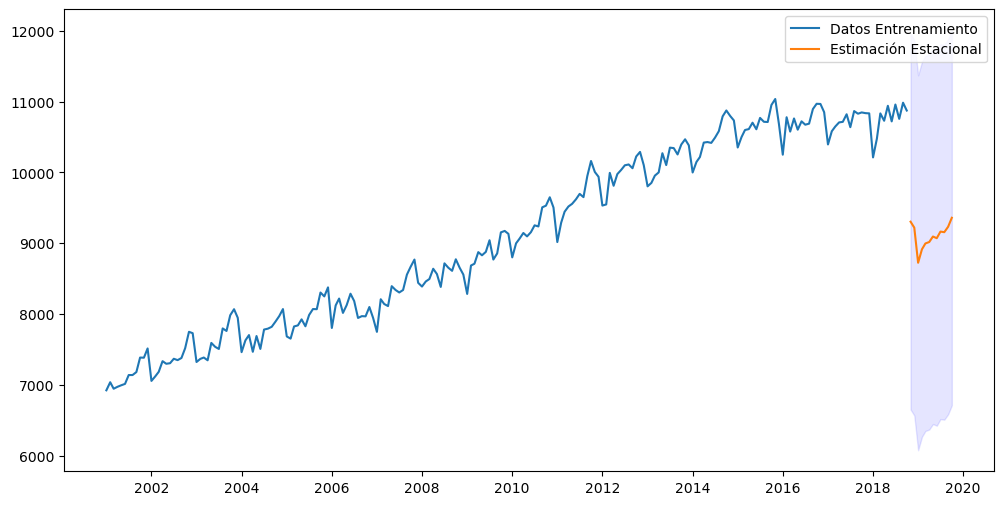

In [499]:
fig = plt.figure(figsize=(12, 6))
plt.plot(y.index,y,label="Datos Entrenamiento")
plt.plot(preds.index,preds['Point_forecast'],label="Estimación Estacional")
plt.fill_between(preds.index,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [500]:
# Tomar y_test del conjunto de prueba
y_test = test_td["Ocupados"]
# Convertir índices de y_test a números para que coincidan con y_prd
y_test.index = range(len(y_test))

# Calcular MAPE directo
mape_result_direct = ((np.abs(y_test - y_prd) / np.abs(y_test))
                      .replace([np.inf, -np.inf], np.nan)
                      .mean() * 100)

# Imprimir MAPE directo
print(f"MAPE : {mape_result_direct}")

print(f"RMSE : {np.sqrt(mean_squared_error(y_test, y_prd))}")


MAPE : nan


C:\Users\CARLOS\AppData\Local\Temp\ipykernel_30168\2945628420.py:7: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape_result_direct = ((np.abs(y_test - y_prd) / np.abs(y_test))


ValueError: Found input variables with inconsistent numbers of samples: [6, 12]

### Tendencia Cubica

In [414]:
month_dummies = pd.get_dummies(train_td.index.month,drop_first=True).set_index(train_td.index)

y = train_td["Ocupados"]
X = sm.add_constant(month_dummies)
sea = sm.OLS(y,X)
season = sea.fit()
print(season.summary())

                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                 -0.040
Method:                 Least Squares   F-statistic:                    0.2730
Date:                Sun, 18 Feb 2024   Prob (F-statistic):              0.990
Time:                        00:02:27   Log-Likelihood:                -1778.9
No. Observations:                 208   AIC:                             3582.
Df Residuals:                     196   BIC:                             3622.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8724.5387    304.347     28.666      0.0

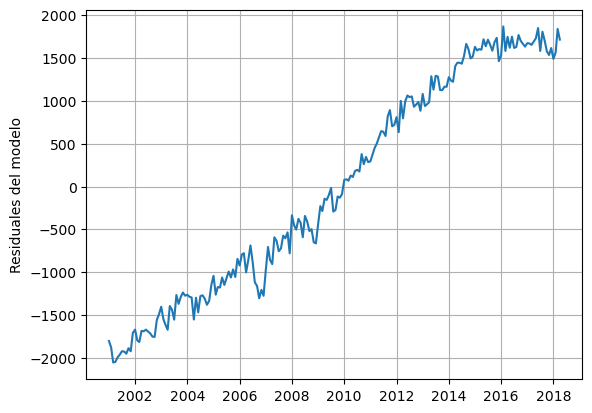

In [415]:
plt.ylabel("Residuales del modelo")
plt.plot(season.resid)
plt.grid()

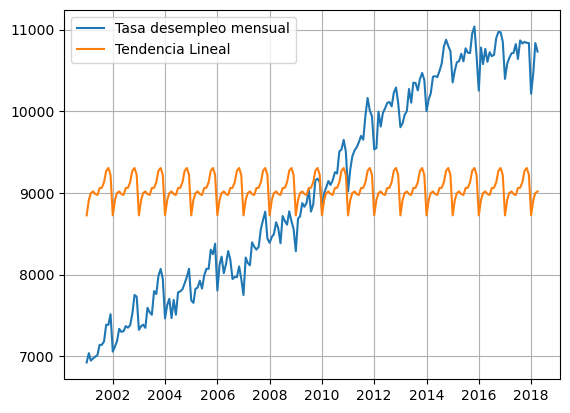

In [416]:
plt.plot(y,label="Tasa desempleo mensual")
plt.plot(season.fittedvalues,label="Tendencia Lineal")
plt.legend()
plt.grid()
plt.show()

In [417]:
range_dates = pd.date_range(train_td.index[-1]+ relativedelta(months=1), periods=12,freq='MS')

x_for = pd.get_dummies(range_dates.month,drop_first=True)
X_for= sm.add_constant(x_for)

In [418]:
dt = season.get_prediction(X_for).summary_frame(alpha = 0.05)
y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']
preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
preds.set_index(range_dates,inplace=True)
print(preds)

            Point_forecast     lower_95      upper_95
2018-05-01     8986.488706  6366.161248  11606.816164
2018-06-01     8974.779765  6354.452307  11595.107223
2018-07-01     9059.390353  6439.062895  11679.717811
2018-08-01     9062.507118  6442.179660  11682.834576
2018-09-01     9129.933235  6509.605777  11750.260693
2018-10-01     9270.852412  6650.524954  11891.179870
2018-11-01     9304.549471  6684.222013  11924.876929
2018-12-01     9220.622941  6600.295483  11840.950399
2019-01-01     8724.538722  6108.258104  11340.819340
2019-02-01     8914.544389  6298.263771  11530.825007
2019-03-01     8997.218333  6380.937715  11613.498951
2019-04-01     9017.681722  6401.401104  11633.962340


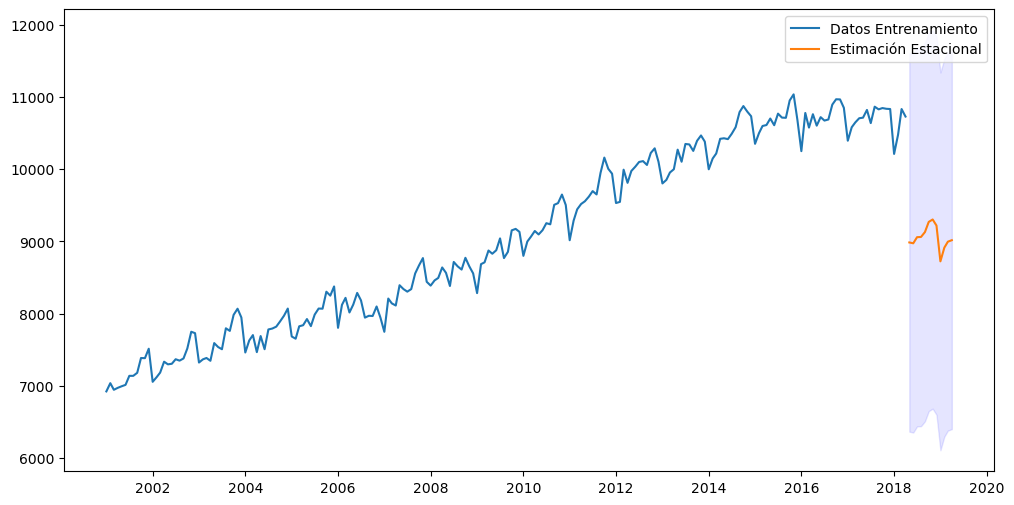

In [419]:
fig = plt.figure(figsize=(12, 6))
plt.plot(y.index,y,label="Datos Entrenamiento")
plt.plot(preds.index,preds['Point_forecast'],label="Estimación Estacional")
plt.fill_between(preds.index,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

### Tendencia + Estacionalidad

In [420]:
y = train_td["Ocupados"]
train_td["x"] = np.linspace(1,train_td.shape[0],train_td.shape[0])
train_td["x2"] = x**2
train_td["x3"] = x**3

month_dummies = pd.get_dummies(train_td.index.month,drop_first=True).set_index(train_td.index)
X = sm.add_constant( pd.concat([train_td[["x","x2","x3"]],month_dummies],axis=1) )
X
season_pol3 = sm.OLS(y,X)
season_pol_3 = season_pol3.fit()
print(season_pol_3.summary())

                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     1002.
Date:                Sun, 18 Feb 2024   Prob (F-statistic):          8.33e-172
Time:                        00:02:32   Log-Likelihood:                -1333.4
No. Observations:                 208   AIC:                             2697.
Df Residuals:                     193   BIC:                             2747.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6977.4189     54.520    127.979      0.0

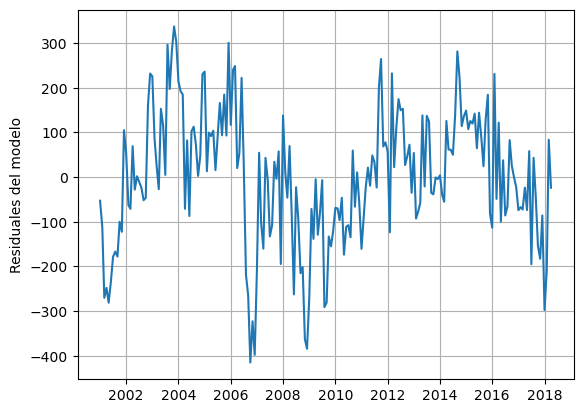

In [421]:
plt.ylabel("Residuales del modelo")
plt.plot(season_pol_3.resid)
plt.grid()

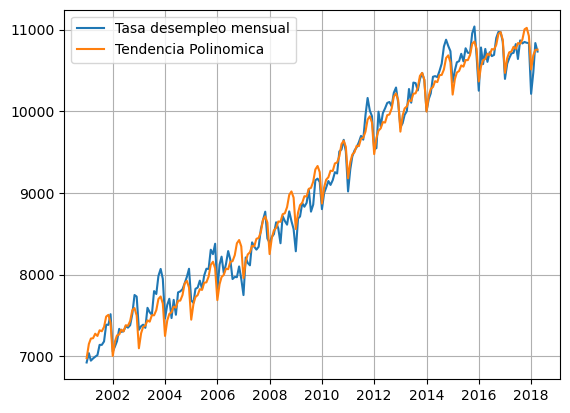

In [422]:
plt.plot(y,label="Tasa desempleo mensual")
plt.plot(season_pol_3.fittedvalues,label="Tendencia Polinomica")
plt.legend()
plt.grid()
plt.show()

In [423]:
h=12
x_for= np.linspace((train_td.shape[0]+1),(train_td.shape[0]+h),h)
x_for_all = pd.DataFrame(np.stack((x_for, x_for**2,x_for**3),axis=1),columns=["x","x2","x3"] )

range_dates = pd.date_range(train_td.index[-1]+ relativedelta(months=1), periods=h,freq='MS')
x_for_dummies = pd.get_dummies(range_dates.month,drop_first=True)

X_for= sm.add_constant(pd.concat([x_for_all,x_for_dummies],axis=1))
X_for

,const,x,x2,x3,2,3,4,5,6,7,8,9,10,11,12
0,1.0,209.0,43681.0,9129329.0,0,0,0,1,0,0,0,0,0,0,0
1,1.0,210.0,44100.0,9261000.0,0,0,0,0,1,0,0,0,0,0,0
2,1.0,211.0,44521.0,9393931.0,0,0,0,0,0,1,0,0,0,0,0
3,1.0,212.0,44944.0,9528128.0,0,0,0,0,0,0,1,0,0,0,0
4,1.0,213.0,45369.0,9663597.0,0,0,0,0,0,0,0,1,0,0,0
5,1.0,214.0,45796.0,9800344.0,0,0,0,0,0,0,0,0,1,0,0
6,1.0,215.0,46225.0,9938375.0,0,0,0,0,0,0,0,0,0,1,0
7,1.0,216.0,46656.0,10077696.0,0,0,0,0,0,0,0,0,0,0,1
8,1.0,217.0,47089.0,10218313.0,0,0,0,0,0,0,0,0,0,0,0
9,1.0,218.0,47524.0,10360232.0,1,0,0,0,0,0,0,0,0,0,0


In [424]:
dt = season_pol_3.get_prediction(X_for).summary_frame(alpha = 0.05)
y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']
preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
preds.set_index(range_dates,inplace=True)
print(preds)

            Point_forecast      lower_95      upper_95
2018-05-01    10806.034428  10484.578439  11127.490416
2018-06-01    10775.150792  10452.960108  11097.341476
2018-07-01    10840.044259  10517.074490  11163.014028
2018-08-01    10822.901476  10499.106433  11146.696518
2018-09-01    10869.525618  10544.857293  11194.193943
2018-10-01    10989.100393  10663.508939  11314.691847
2018-11-01    11000.910623  10674.344339  11327.476907
2018-12-01    10894.554838  10566.960158  11222.149518
2019-01-01    10478.326239  10149.513966  10807.138513
2019-02-01    10645.801704  10315.853454  10975.749954
2019-03-01    10705.372885  10374.229800  11036.515969
2019-04-01    10702.160948  10369.762251  11034.559646


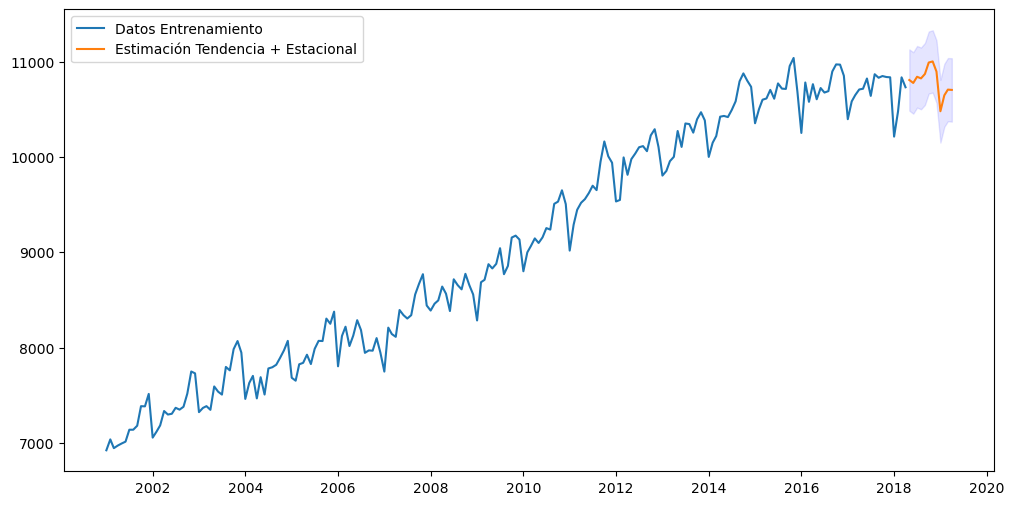

In [425]:
fig = plt.figure(figsize=(12, 6))
plt.plot(y.index,y,label="Datos Entrenamiento")
plt.plot(preds.index,preds['Point_forecast'],label="Estimación Tendencia + Estacional")
plt.fill_between(preds.index,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [426]:
# Tomar y_test del conjunto de prueba
y_test = test_td["Ocupados"]
# Convertir índices de y_test a números para que coincidan con y_prd
y_test.index = range(len(y_test))

# Calcular MAPE directo
mape_result_direct = ((np.abs(y_test - y_prd) / np.abs(y_test))
                      .replace([np.inf, -np.inf], np.nan)
                      .mean() * 100)

# Imprimir MAPE directo
print(f"MAPE : {mape_result_direct}")

print(f"RMSE : {np.sqrt(mean_squared_error(y_test, y_prd))}")


MAPE : 0.9757896187523254
RMSE : 115.36758296427509


In [501]:
print('hola')

hola
